# BE/Bi 103, Fall 2015: Homework 6

## Due 1pm, Monday, November 16

*This document was generated from a Jupyter notebook.  You can download the notebook [here](hw6.ipynb).*

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



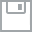
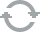
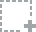
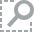
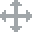
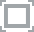
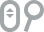
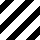
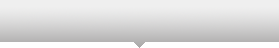
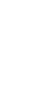
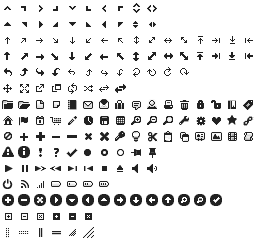
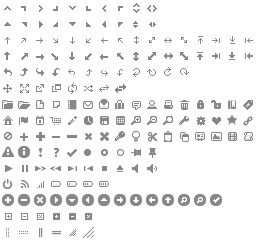
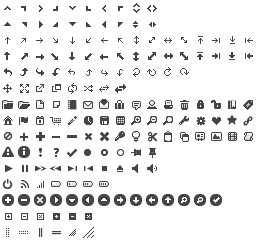
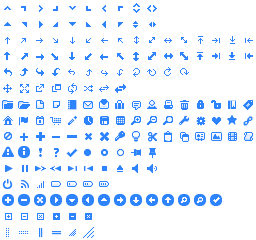
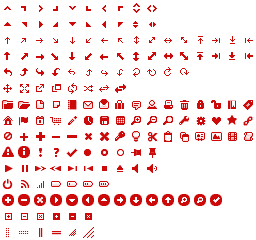
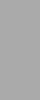
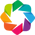
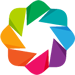

In [1]:
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.misc
import scipy.stats as st

# The MCMC Hammer
import emcee

# BE/Bi 103 utilities
import bebi103

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.io
import bokeh.plotting

# Display graphics in this notebook
bokeh.io.output_notebook()

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Problem 6.1: Microtubule catastrophe, 70 pts + 15 pts extra credit

In [Homework 1](hw1.html), we plotted data of microtubule catastrophe times.  In this problem, we return to the data from the [Gardner, Zanic, et al. paper](../protected/papers/gardner_2011.pdf)  We will carefully analyze the data and make some conclusions about the processes underlying microtubule catastrophe.  You can download the data set [here](../protected/data/gardner_hw6.zip).

In the file `gardner_mt_catastrophe_only_tubulin.csv`, we have observed catastrophe times of microtubules with different concentrations of tubulin.  So, our data set $D$ consists of a set of measurements of the amount of time to catastrophe; $D = \{t_i\}$.  To model microtuble catastrophe, we will assume that a series of $m$,  processes must occur sequentially to trigger catastrophe.  This could be separate depolymerization events, binding of auxiliary proteins, etc.  We assume that each of these processes is a Poisson process, and that process $j$ occurs with rate $1/\tau_j$.  Our goal here is to do model selection to determine the value of $m$.

As we have learned, the model specifies the likelihood.  We will assume all microtubule catastrophes are independent, so the likelihood for all of our observed catastrophes 

\begin{align}
P(D\mid \boldsymbol{\tau}, m, I) = \prod_i P(t_i\mid \boldsymbol{\tau}, m, I).
\end{align}

**a)** Explain why the probability distribution for catastrophe times for a three-step process ($m=3$) is

\begin{align}
P(t\mid \tau_1, \tau_2, \tau_3, 3, I) = \frac{1}{\tau_1\tau_2\tau_3}\int_0^t\mathrm{d}t_1 \int_{t_1}^t\mathrm{d}t_2\, \mathrm{e}^{-t_1/\tau_1}\,\mathrm{e}^{-(t_2-t_1)/\tau_2}\,\mathrm{e}^{-(t-t_2)/\tau_3}.
\end{align}

**b)** The above expression for general $m$ can be integrated, giving

\begin{align}
P(t\mid \boldsymbol{\tau}, m, I) = \sum_{j=1}^m \frac{\tau_j^{m-2}\,\mathrm{e}^{-t/\tau_j}}{\prod_{k=1,k\ne j}^m (\tau_j - \tau_k)}.
\end{align}

For clarity, the probability distributions for the first few $m$ are

\begin{align}
P(t\mid \tau_1, 1, I) &= \frac{\mathrm{e}^{-t/\tau_1}}{\tau_1},\\[1em]
P(t\mid \tau_1, \tau_2, 2, I) &=
\frac{\mathrm{e}^{-t/\tau_1}}{\tau_1 - \tau_2} + \frac{\mathrm{e}^{-t/\tau_2}}{\tau_2 - \tau_1}
= \frac{\mathrm{e}^{-t/\tau_2} - \mathrm{e}^{-t/\tau_1}}{\tau_2 - \tau_1} \\[1em]
P(t\mid \tau_1, \tau_2, \tau_3, 3, I) &=
\frac{\tau_1\,\mathrm{e}^{-t/\tau_1}}{(\tau_1 - \tau_2)(\tau_1-\tau_3)}
+\frac{\tau_2\,\mathrm{e}^{-t/\tau_2}}{(\tau_2 - \tau_1)(\tau_2-\tau_3)}
+\frac{\tau_3\,\mathrm{e}^{-t/\tau_3}}{(\tau_3 - \tau_1)(\tau_3-\tau_2)}
\end{align}

Note that these probability distributions assume that no two of the $\tau_j$'s are equal, and you should explicitly ensure this in your calculations.  If any two $\tau_j$'s are equal, you need to take a limit, e.g.,

\begin{align}
\lim_{\tau_2\to\tau_1} P(t\mid \tau_1, \tau_2, 2, I) &= \frac{t^2}{2\tau_1}\,\mathrm{e}^{-t/\tau_1},
\end{align}

in this case, as gamma distribution.  Not to worry; we will not include this limit in our analysis here.

In fact, you should specify $\tau_1 < \tau_2 < \cdots < \tau_n$.  Why is this ok to do, and why should you do it?

**c)** For the trials where the tubulin concentration is 12 µM (from the file `gardner_mt_catastrophe_only_tubulin.csv`), perform parameter estimation for the $\{\tau_j\}$ and model selection for various values of $m$.  Report the results with clear graphics and discussion.  

*Hint*: Computing the log of the sum of exponentials while dealing with machine precision is a tricky business, and something that comes up often in probability.  Here is my advice.  Say you are computing $\ln(\mathrm{e}^a - \mathrm{e}^b + \mathrm{e}^c)$ with $a>b>c$.  We have

\begin{align}
\ln(\mathrm{e}^a - \mathrm{e}^b + \mathrm{e}^c) = \ln\left(\mathrm{e}^a(1 - \mathrm{e}^{b-a} + \mathrm{e}^{c-a})\right)
= a + \ln(1 - \mathrm{e}^{b-a} + \mathrm{e}^{c-a}).
\end{align}

This latter expression is much easier to compute numerically because all entries in the sum inside the logarithm at less than or equal to one, given that $a$ is the largest argument to the exponentials.

**d)** Using whichever model you found most probable when you computed the odds ratio for the 12 µM tubulin measurements, find the values of the $\tau_j$'s for the other concentrations of tubulin.  Given that microtubules polymerize faster with higher tubulin concentrations, is there anything you can say about the occurrence of catastrophe by looking at the values of the $\tau_j$'s versus tubulin concentration?

**e) (15 points extra credit)** In the files `gardner_mt_catastrophe_kip3.csv` and `gardner_mt_catastrophe_mcak.csv`, there are measurements of catastrophe times in the presence of the kinesins Kip3 and MCAK with 12 µM tubulin.  Analyze these data and discuss conclusions about their respective roles in microtubule catastrophe.  *Note*: This part of the problem is intentionally open-ended.  You should think carefully, and perform a complete analysis to draw your conclusions.

### Problem 6.1: solution

**a)** To be added.

**b)** If we order the $\tau_j$'s, we can write

\begin{align}
P(t\mid \boldsymbol{\tau}, m, I) = \sum_{j=1}^m (-1)^{m-j}\,\frac{\tau_j^{m-2}\,\mathrm{e}^{-t/\tau_j}}{\prod_{k=1,k\ne j}^m \left|\tau_j - \tau_k\right|}.
\end{align}

This enables us to write the sum as

\begin{align}
P(t\mid \boldsymbol{\tau}, m, I)  = \sum_{j=1}^m (-1)^{m-j}\, \exp\left\{-\frac{t}{\tau_j} + (m-2) \ln \tau_j - \sum_{k=1,k\ne j}^m \ln\left|\tau_j-\tau_k\right|\right\}.
\end{align}

The likelihood is then

\begin{align}
P(D\mid \boldsymbol{\tau}, m, I) = \prod_i\left(
\sum_{j=1}^m (-1)^{m-j}\, \exp\left\{-\frac{t_i}{\tau_j} + (m-2) \ln \tau_j - \sum_{k=1,k\ne j}^m \ln\left|\tau_j-\tau_k\right|\right\}
\right),
\end{align}

giving a log likelihood of

\begin{align}
\ln P(D\mid \boldsymbol{\tau}, m, I) = \sum_i \ln\left(\sum_{j=1}^m (-1)^{m-j}\, \exp\left\{-\frac{t_i}{\tau_j} + (m-2) \ln \tau_j - \sum_{k=1,k\ne j}^m \ln\left|\tau_j-\tau_k\right|\right\}\right).
\end{align}

**c)** First, let's load in the data, tidy it, and extract our times of interest.

In [14]:
# Load the data set
fname = '../data/gardner_et_al/gardner_mt_catastrophe_only_tubulin.csv'
df = pd.read_csv(fname, comment='#')

# Tidy the DataFrame
df = pd.melt(df, var_name='tubulin conc (µM)', 
             value_name='time to catastrophe (s)')
df = df.dropna()

# Convert concentrations from string to numbers
df['tubulin conc (µM)'] = \
        df['tubulin conc (µM)'].str.extract('(\d+)').astype(int)

# Pull our t, and have it sorted for convenience
t = df[df['tubulin conc (µM)']==12]['time to catastrophe (s)'].values
t.sort()

Now let's plot an ECDF just so we can see what we're dealing with.

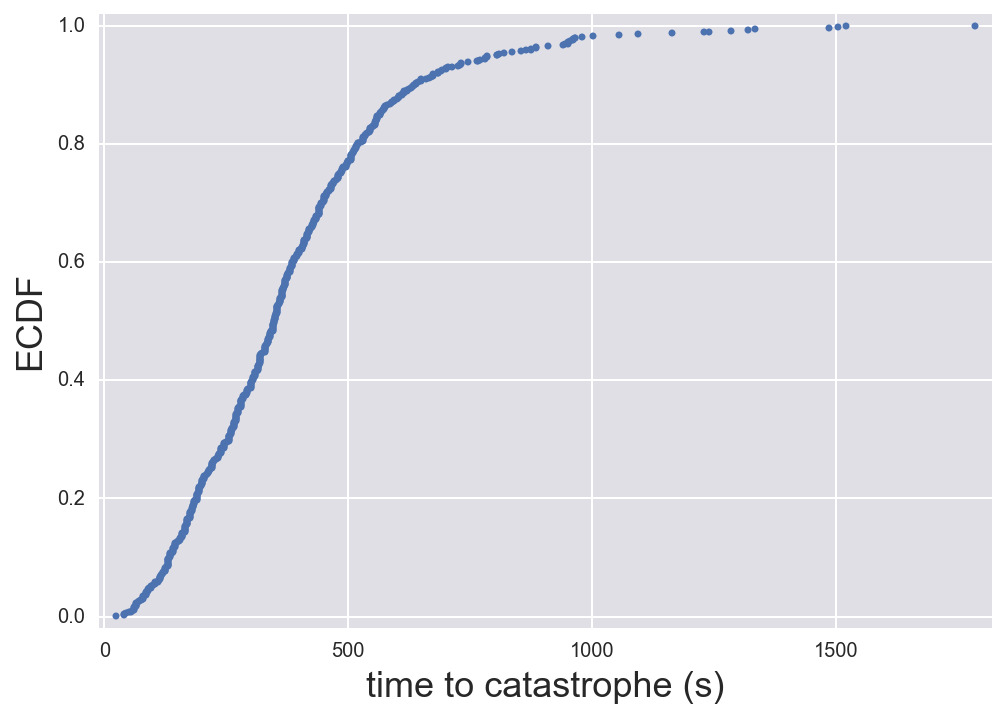

In [15]:
# Construct ECDF
y = np.arange(1, len(t) + 1) / len(t)
plt.plot(t, y, '.')
plt.xlabel('time to catastrophe (s)')
plt.ylabel('ECDF')
plt.margins(0.02)

Now, we'll define our log likelihood.  We'll first write a function to compute the PDF and then use that in the log likelihood function.  Importantly, we need to use the logsumexp trick to compute the log of the sum of exponentials.  Otherwise, we will run into trouble with underflow.

In [16]:
# Probability distribution
def log_pdf(t, tau):
    """
    Theoretical pdf.
    """ 
    # Number of data points
    n = len(t)
    
    # Number of Poisson processes
    m = len(tau)
    
    # Scale for logsumexp
    b = np.empty((1, m), dtype=int)
    if (m % 2) == 0:
        b[0,::2] = -1
        b[0,1::2] = 1
    else:
        b[0,::2] = 1
        b[0,1::2] = -1    

    # Set up arguments of exponentials in sum
    exp_args = np.empty((n, m), dtype=np.float)
    for j, tau_j in enumerate(tau):
        sum_logs = np.sum(np.log(np.abs(tau[:j] - tau[j]))) \
                        + np.sum(np.log(np.abs(tau[j+1:] - tau[j])))
        exp_args[:,j] = -t / tau_j + (m - 2) * np.log(tau_j) - sum_logs

    return scipy.misc.logsumexp(exp_args, b=b, axis=1)

Now we can code up the log likelihood.

In [17]:
def log_likelihood(tau, t):
    """
    Log likelihood using sp.misc.logsumexp()
    """
    # Compute special case first
    if m == 1:
        return -len(t) * np.log(tau[0]) - t.sum() / tau[0]
    else:
        return log_pdf(t, tau).sum()

The log likelihood is a complicated function.  It is generally a good idea with any function, especially a complicated one, to test it for simple test cases.  We'll therefore write a testing function that works for $m \in \{1,2,3,4\}$.  The test function does not explicitly deal with the precision issues, but if we choose the right $\tau$'s, it will work.

In [21]:
def test_log_likelihood(tau, t):
    """
    Check log likelihood function for first few values of m
    """
    # Number of data points
    n = len(t)
        
    # Number of Poisson processes
    m = len(tau)
    
    # Compute log likelihood for special cases
    if m == 1:
        log_like = -n * np.log(tau[0]) - t.sum() / tau[0]
    
    if m == 2:
        log_like = np.sum(np.log(
                (np.exp(-t/tau[1]) - np.exp(-t/tau[0])) / (tau[1] - tau[0])))
    
    if m == 3:
        log_like = np.sum(np.log(
            np.exp(-t/tau[0]) * tau[0] / (tau[0] - tau[1]) / (tau[0] - tau[2]) \
          + np.exp(-t/tau[1]) * tau[1] / (tau[1] - tau[0]) / (tau[1] - tau[2]) \
          + np.exp(-t/tau[2]) * tau[2] / (tau[2] - tau[0]) / (tau[2] - tau[1])))
    
    if m == 4:
        tau_prods = [(tau[0] - tau[1]) * (tau[0] - tau[2]) * (tau[0] - tau[3]),
                     (tau[1] - tau[0]) * (tau[1] - tau[2]) * (tau[1] - tau[3]),
                     (tau[2] - tau[0]) * (tau[2] - tau[1]) * (tau[2] - tau[3]),
                     (tau[3] - tau[0]) * (tau[3] - tau[1]) * (tau[3] - tau[2])]
        log_like =  np.sum(np.log(
                np.exp(-t/tau[0]) * tau[0]**2 / tau_prods[0] \
              + np.exp(-t/tau[1]) * tau[1]**2 / tau_prods[1] \
              + np.exp(-t/tau[2]) * tau[2]**2 / tau_prods[2] \
              + np.exp(-t/tau[3]) * tau[3]**2 / tau_prods[3]))
    
    # Make sure we got the right values
    if np.isfinite(log_like):
        assert np.isclose(log_likelihood(tau, t), log_like)
    else:
        print('Infinite log likelihood test value.')

Now that we have the test function, we can try it for dummy values of `t` and `tau`.  If no `AssertionError` come up, then we know it passed the tests.  We'll generate 20 random times, and then try 100 random sets of $\tau$'s for each $m$ that we test.

In [22]:
test_t = np.random.uniform(0, 10, 20)

for m in [2, 3, 4]:
    test_tau = np.random.uniform(0, 1, (100, m))
    test_tau = np.sort(test_tau, axis=1)
    for i in range(len(test_tau)):
        test_log_likelihood(test_tau[i,:], test_t)

Success!  Our function works as we expect, so we will go forward using it.

We next need to define the prior.  We need to make sure the $\tau$'s are rank ordered and positive.  If they are, we take a Jeffreys prior for each $\tau$, which we consider to be independent.  Since the the value of $\tau_j$ determines the lower bound of $\tau_{j+1}$, we could define our prior as

\begin{align}
P(\boldsymbol{\tau}\mid m, I) = \left\{\begin{array}{ccl}
 \frac{1}{\tau_1\ln(\tau_{2}/\tau_\mathrm{min})}\, \frac{1}{\tau_m\ln(\tau_\mathrm{max}/\tau_{m-1})}\,\displaystyle{\prod_{j=2}^{m-1}}\frac{1}{\tau_j\ln(\tau_{j+1}/\tau_{j-1})}&&\tau_\mathrm{min} < \tau_1 < \cdots < \tau_m < \tau_\mathrm{max} \\[1em]
 0 & & \text{otherwise}.
\end{array}\right.
\end{align}

The problem with this is that this prior is now highly informative in that it strongly pushes for equal $\tau$'s, since $1/\ln(\tau_{j+1}/\tau_{j-1})$ diverges as $\tau_{j-1} \to \tau_{j+1}$.  This comes from the fact that we specifically labeled $\tau$'s.  We will therefore instead take our prior to be

\begin{align}
P(\boldsymbol{\tau}\mid m, I) = \left\{\begin{array}{ccl}
\left[\ln(\tau_\mathrm{max}/\tau_\mathrm{min})\right]^{-m}\,\prod_{j=1}^m\tau_j^{-1}&&\tau_\mathrm{min} < \tau_1 < \cdots < \tau_m < \tau_\mathrm{max} \\[1em]
 0 & & \text{otherwise}.
\end{array}\right.
\end{align}

We will take $\tau_\mathrm{min} = 1$ sec as a lower bound.  For an upper bound, we will take $\tau_\mathrm{max} = 2000$ sec, which is about a half hour.  I picked this value because I know that spindles are built in at least that amount of time and the microtubules in them undergo polymerization and catastrophe multiple times.

In [23]:
def log_prior(tau, tau_min, tau_max, eps=1e-6):
    """
    Log prior for successive Poisson processes model.
    """  
    if (tau[0] <= tau_min) or (tau[-1] >= tau_max) or (np.diff(tau) < eps).any():
        return -np.inf
    
    return -np.log(tau).sum() - len(tau) * np.log(np.log(tau_max / tau_min))

So now we have a log likelihood and a log prior.  We just need to get initial conditions for walkers, and we can perform MCMC.

In [24]:
def walker_starting_points(m, n_temps, n_walkers, tau_min, tau_max):
    """
    Generate walker starting positions for PTMCMC
    """
    p0 = np.random.uniform(tau_min, tau_max, (n_temps, n_walkers, m))
    p0 = np.sort(p0, axis=2)
    return p0

We'll write a function to do the PTMCMC sampling for our model.  We will start our walkers closer to what we expect the MAP to be, i.e., with $\tau_j < 300$ seconds, which is the typical time it takes to undergo catastrope.

In [25]:
def sample_ptmcmc(t, m, tau_min=1, tau_max=2000, n_temps=20, n_walkers=100, 
                  n_burn=100, n_steps=500, threads=None):
    
    # Starting points of walkers
    p0 = walker_starting_points(m, n_temps, n_walkers, tau_min, 300)
    
    # Columns for output DataFrame
    columns = ['tau_' + str(i) + ' (s)' for i in range(1, m+1)]
    
    return bebi103.run_pt_emcee(
        log_likelihood, log_prior, n_burn, n_steps, n_temps=n_temps, p0=p0, 
        loglargs=(t,), logpargs=(tau_min, tau_max), threads=threads, 
        columns=columns, return_lnZ=False)

Finally, we write a function to compute the likelihood for the model, $\ln Z(1)$.  This is done automatically by `emcee`, but we will write our own to parse `DataFrame`s later.

In [26]:
def lnZ(df_mcmc):
    """
    Compute log Z(1) from PTMCMC traces stored in DataFrame.
    """
    # Average the log likelihood over the samples
    log_mean = np.zeros(len(df_mcmc['beta_ind'].unique()))
    for i, b in enumerate(df_mcmc['beta_ind'].unique()):
        log_mean[i] = df_mcmc['lnlike'][df_mcmc['beta_ind']==b].mean()

    # Set of betas (temperatures)
    betas = np.concatenate((np.array(df_mcmc['beta'].unique()), (0,)))

    # Approximate quadrature
    return np.dot(log_mean, -np.diff(betas))

Let's first do PTMCMC!  We'll test up to $m_\mathrm{max} = 6$.  We'll do each set of samples and then save it to disk so as to conserve RAM.  Also, if we end up redoing some calculation, we can always just reload the samples instead of re-sampling.

**Warning**: This will take a long time.  It took about three hours on my machine.

In [27]:
m_max = 6
lnZ_taus = dict()
for m in range(1, m_max+1):
    fname = 'ptmcmc_results_tau_' + str(m) + '.csv'
    try:
        # Try loading if we already did the calculation
        print('Attempting to load {0:s}....'.format(fname), end=' ', 
              flush=True)
        df_ = pd.read_csv(fname)
        print('Success!')
    except:
        # Run PTMCMC
        print('Failed!')
        print('Performing MCMC for m = {0:d}....'.format(m), flush=True)
        df_ = sample_ptmcmc(t, m, tau_min=1, tau_max=2000, n_temps=20, 
                            n_walkers=100, n_burn=10000, n_steps=20000, 
                            threads=6)

        # Save result to DataFrame
        df_.to_csv(fname, index=False, float_format='%.3e')

    # Compute lnZ
    lnZ_taus[m] = lnZ(df_)
    
# Store lnZ's in a DataFrame
df_model_selection = pd.DataFrame(data=lnZ_taus, index=['lnZ']).transpose()

Attempting to load ptmcmc_results_tau_1.csv.... Failed!
Performing MCMC for m = 1....
Attempting to load ptmcmc_results_tau_2.csv.... Failed!
Performing MCMC for m = 2....
Attempting to load ptmcmc_results_tau_3.csv.... Failed!
Performing MCMC for m = 3....
Attempting to load ptmcmc_results_tau_4.csv.... Failed!
Performing MCMC for m = 4....
Attempting to load ptmcmc_results_tau_5.csv.... Failed!
Performing MCMC for m = 5....
Attempting to load ptmcmc_results_tau_6.csv.... Failed!
Performing MCMC for m = 6....


We can now compute the odds ratios.

In [28]:
df_model_selection['odds_ratio'] = \
        np.exp(df_model_selection.loc[1, 'lnZ'] - df_model_selection['lnZ'])
    
df_model_selection

lnZ    odds_ratio
1 -4805.123614  1.000000e+00
2 -4665.493220  2.287126e-61
3 -4640.956030  5.045732e-72
4 -4641.028877  5.427019e-72
5 -4641.535617  9.008145e-72
6 -4642.301092  1.936766e-71

If we limit our universe of possilities to the six models we have considered, we can compute the absolute probabilities of each model.

In [29]:
df_model_selection['lnprob'] = df_model_selection['lnZ'] \
                        - scipy.misc.logsumexp(df_model_selection['lnZ'])
    
df_model_selection['prob'] = np.exp(df_model_selection['lnprob'])

# Take a look
df_model_selection

lnZ    odds_ratio      lnprob          prob
1 -4805.123614  1.000000e+00 -165.179329  1.834547e-72
2 -4665.493220  2.287126e-61  -25.548935  8.021188e-12
3 -4640.956030  5.045732e-72   -1.011745  3.635840e-01
4 -4641.028877  5.427019e-72   -1.084592  3.380396e-01
5 -4641.535617  9.008145e-72   -1.591331  2.036543e-01
6 -4642.301092  1.936766e-71   -2.356807  9.472217e-02

So, there is no chance that microtubule catastrophe is a one-step or two-step process.  We plot the probabilities.

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


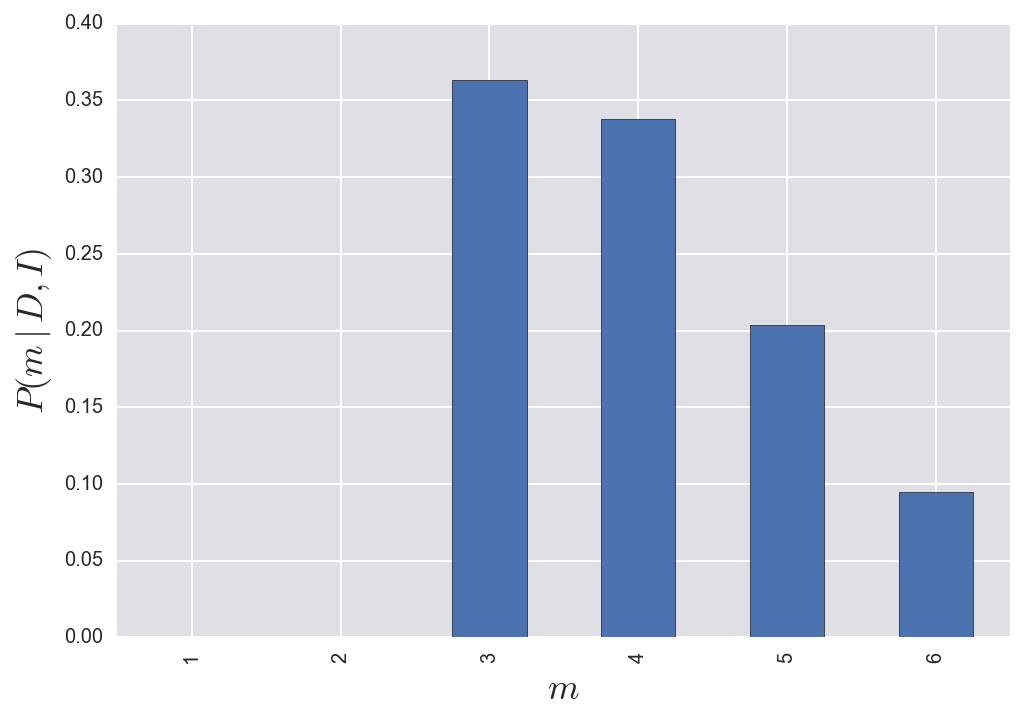

In [31]:
df_model_selection['prob'].plot(kind='bar', color=sns.color_palette()[0])
plt.xlabel('$m$')
plt.ylabel(r'$P(m\mid D, I)$');

So, one- and two- step processes are out of the question.  A three-step process is most likely, with higher-step processes being possible with decreasing probability.  To further analyze these results, let's assess the sampling using corner plots.  We will make them one-by-one for display purposes.  The number of steps is obvious from the dimension of each corner plot.

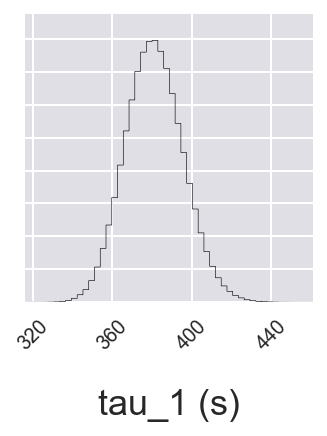

In [32]:
m = 1
df_ = pd.read_csv('ptmcmc_results_tau_' + str(m) + '.csv')
corner.corner(df_[df_.beta_ind==0].filter(regex='tau'), bins=50);

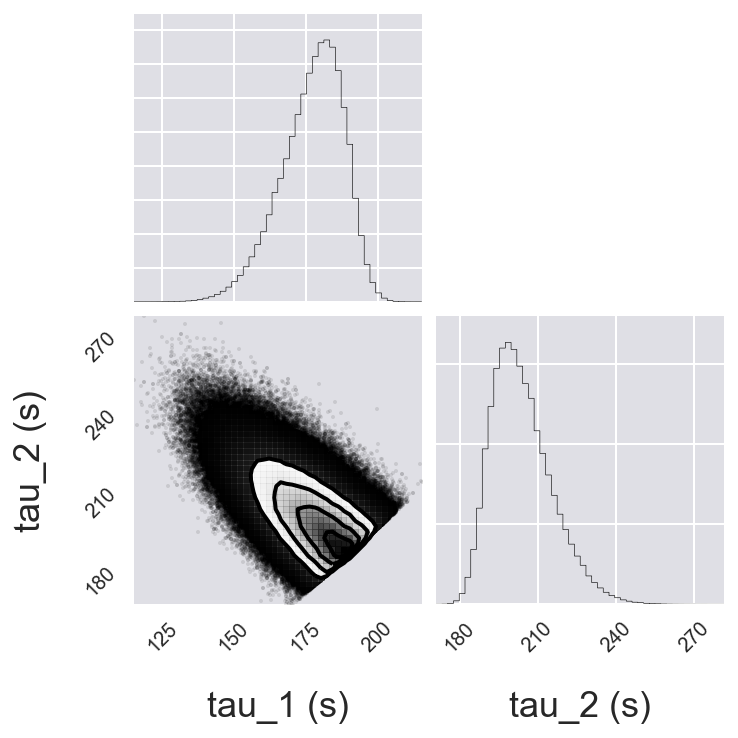

In [33]:
m = 2
df_ = pd.read_csv('ptmcmc_results_tau_' + str(m) + '.csv')
corner.corner(df_[df_.beta_ind==0].filter(regex='tau'), bins=50);

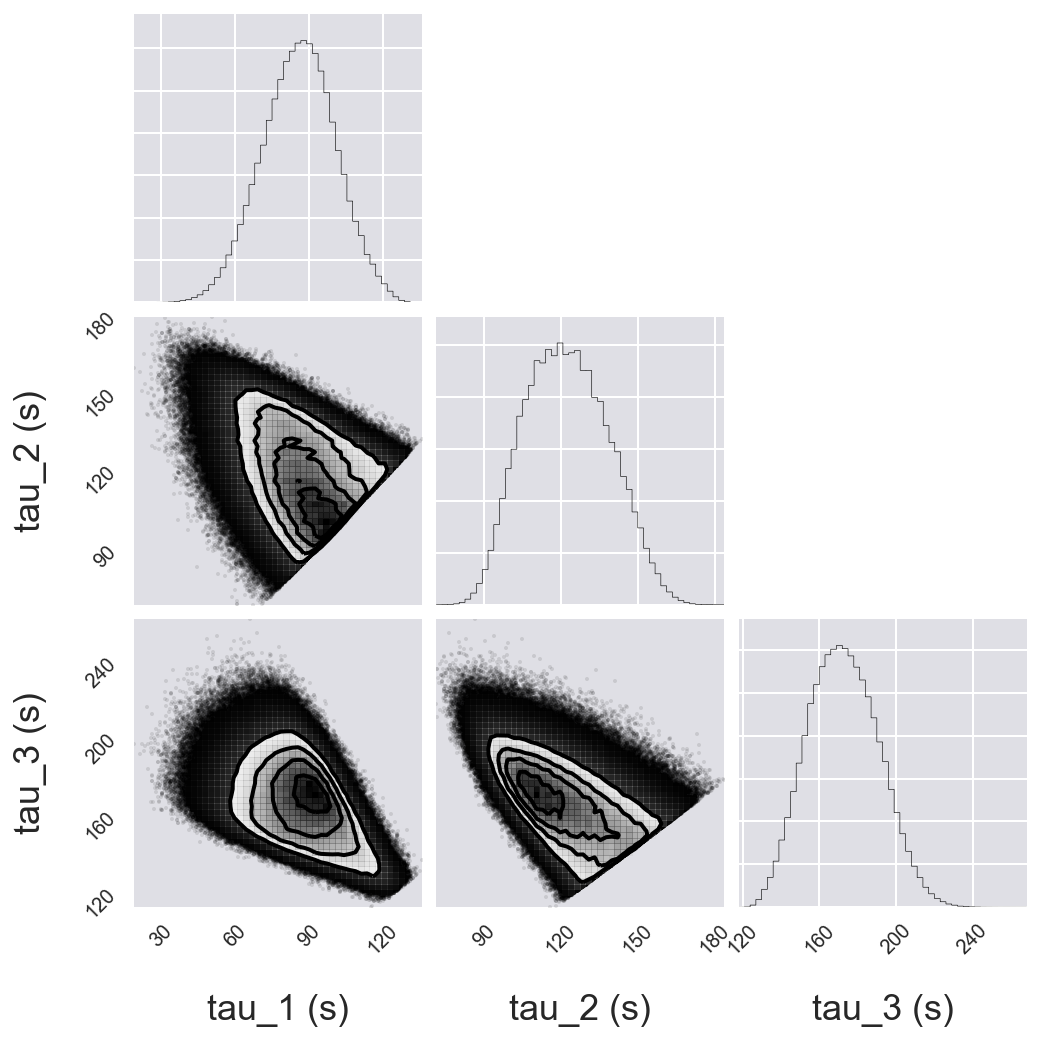

In [34]:
m = 3
df_ = pd.read_csv('ptmcmc_results_tau_' + str(m) + '.csv')
corner.corner(df_[df_.beta_ind==0].filter(regex='tau'), bins=50);

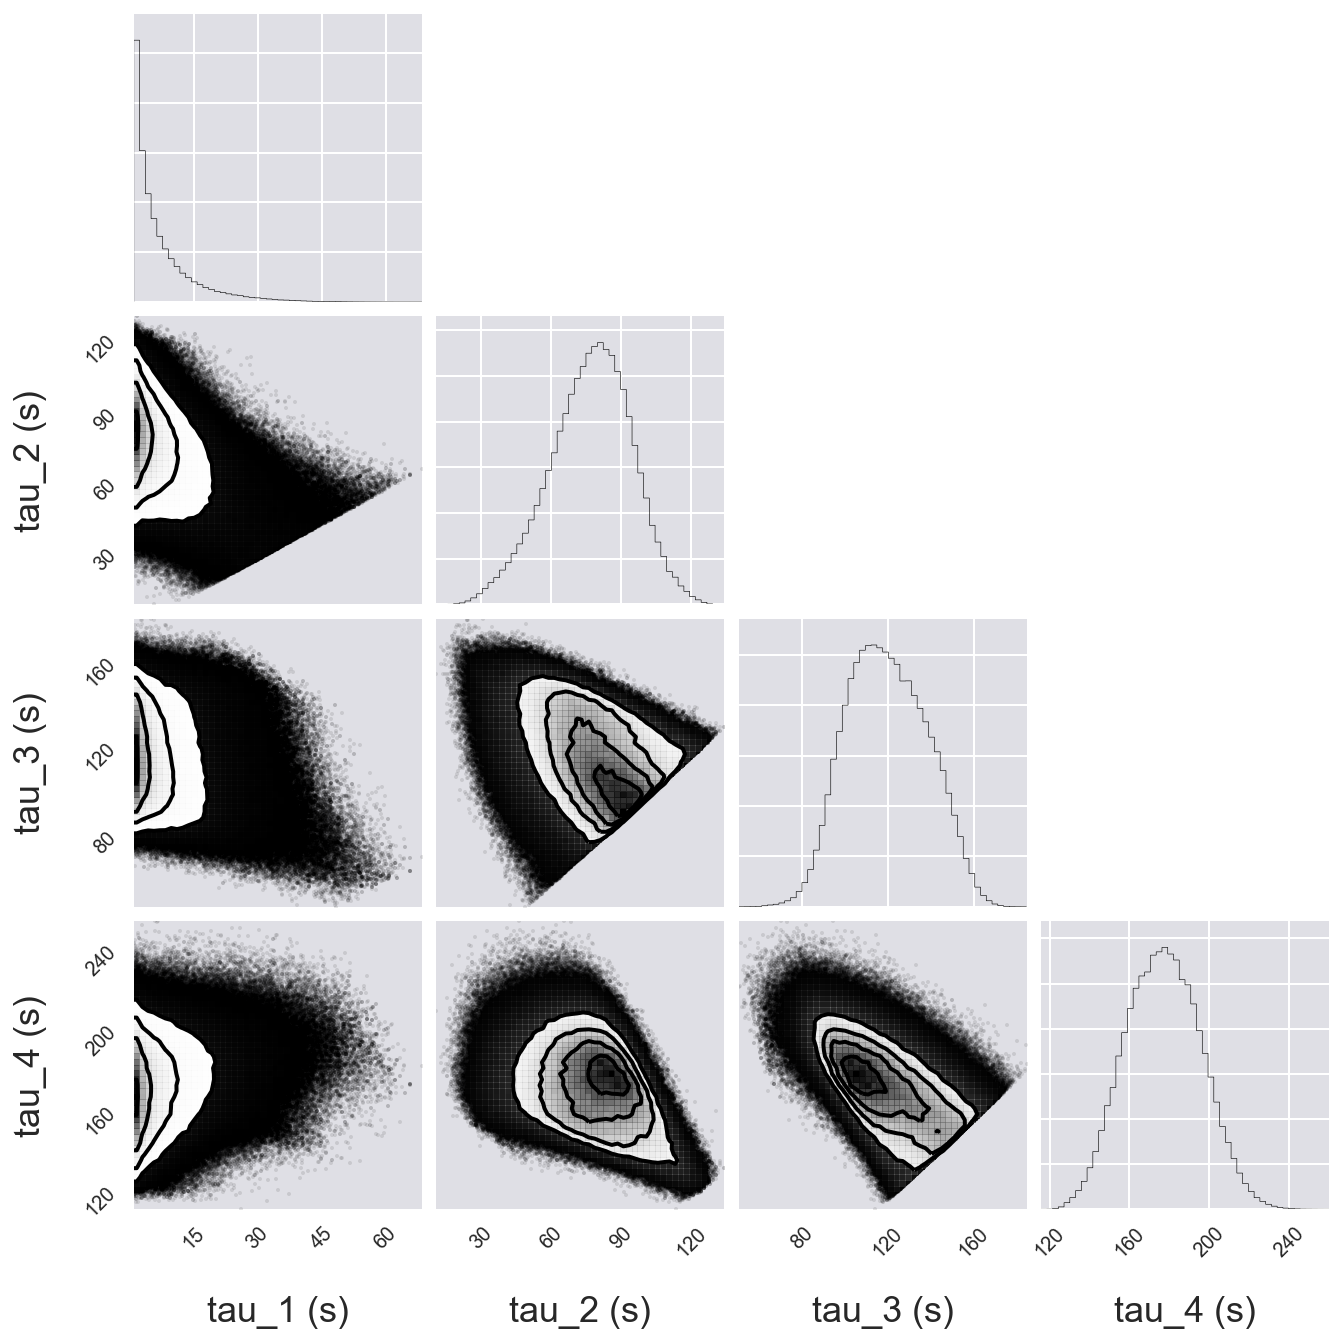

In [35]:
m = 4
df_ = pd.read_csv('ptmcmc_results_tau_' + str(m) + '.csv')
corner.corner(df_[df_.beta_ind==0].filter(regex='tau'), bins=50);

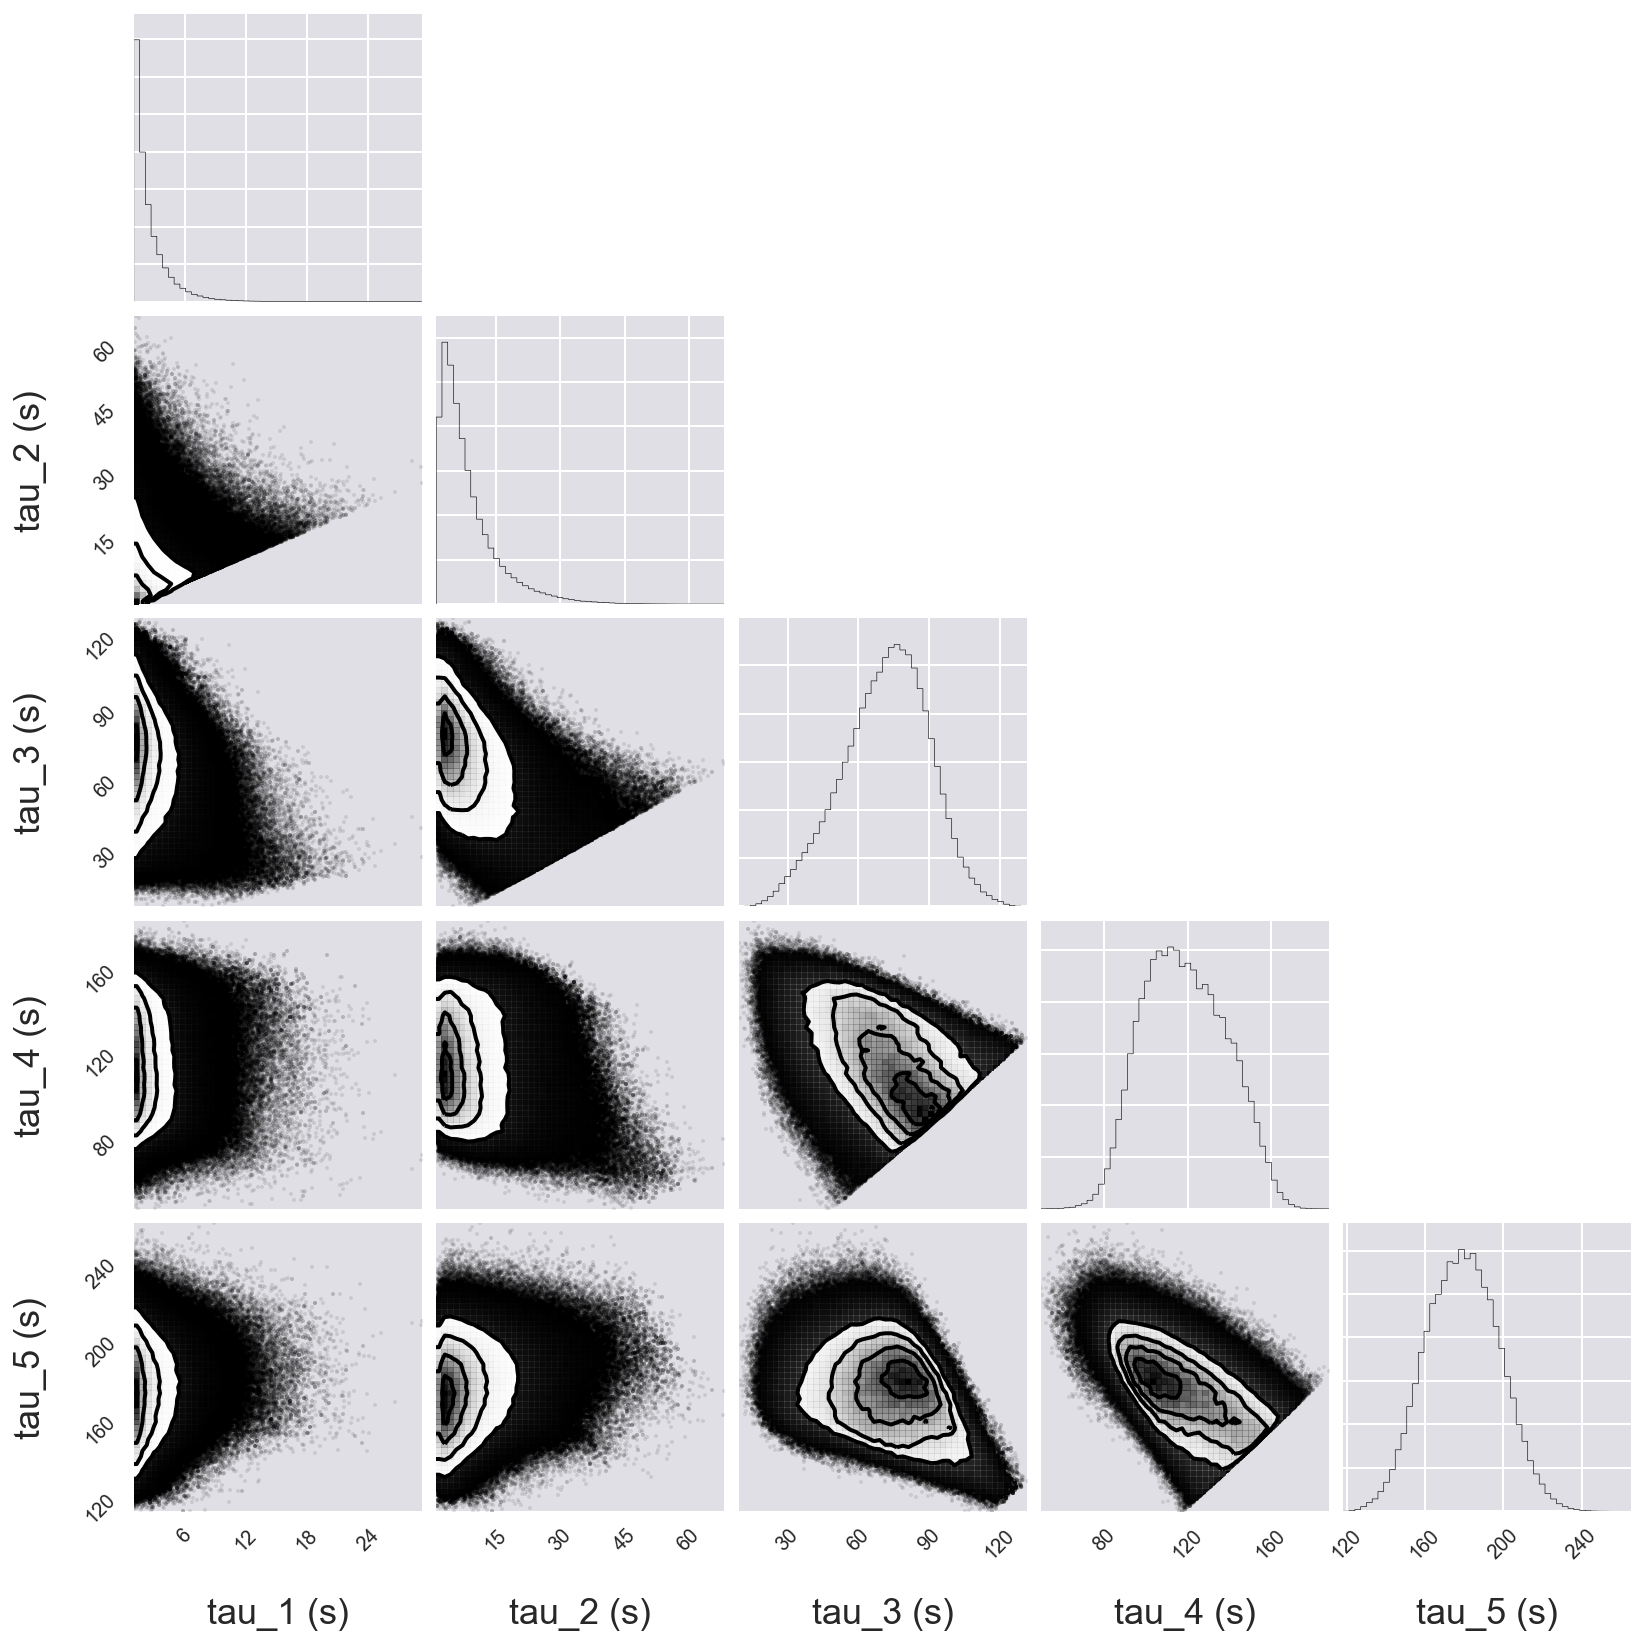

In [36]:
m = 5
df_ = pd.read_csv('ptmcmc_results_tau_' + str(m) + '.csv')
corner.corner(df_[df_.beta_ind==0].filter(regex='tau'), bins=50);

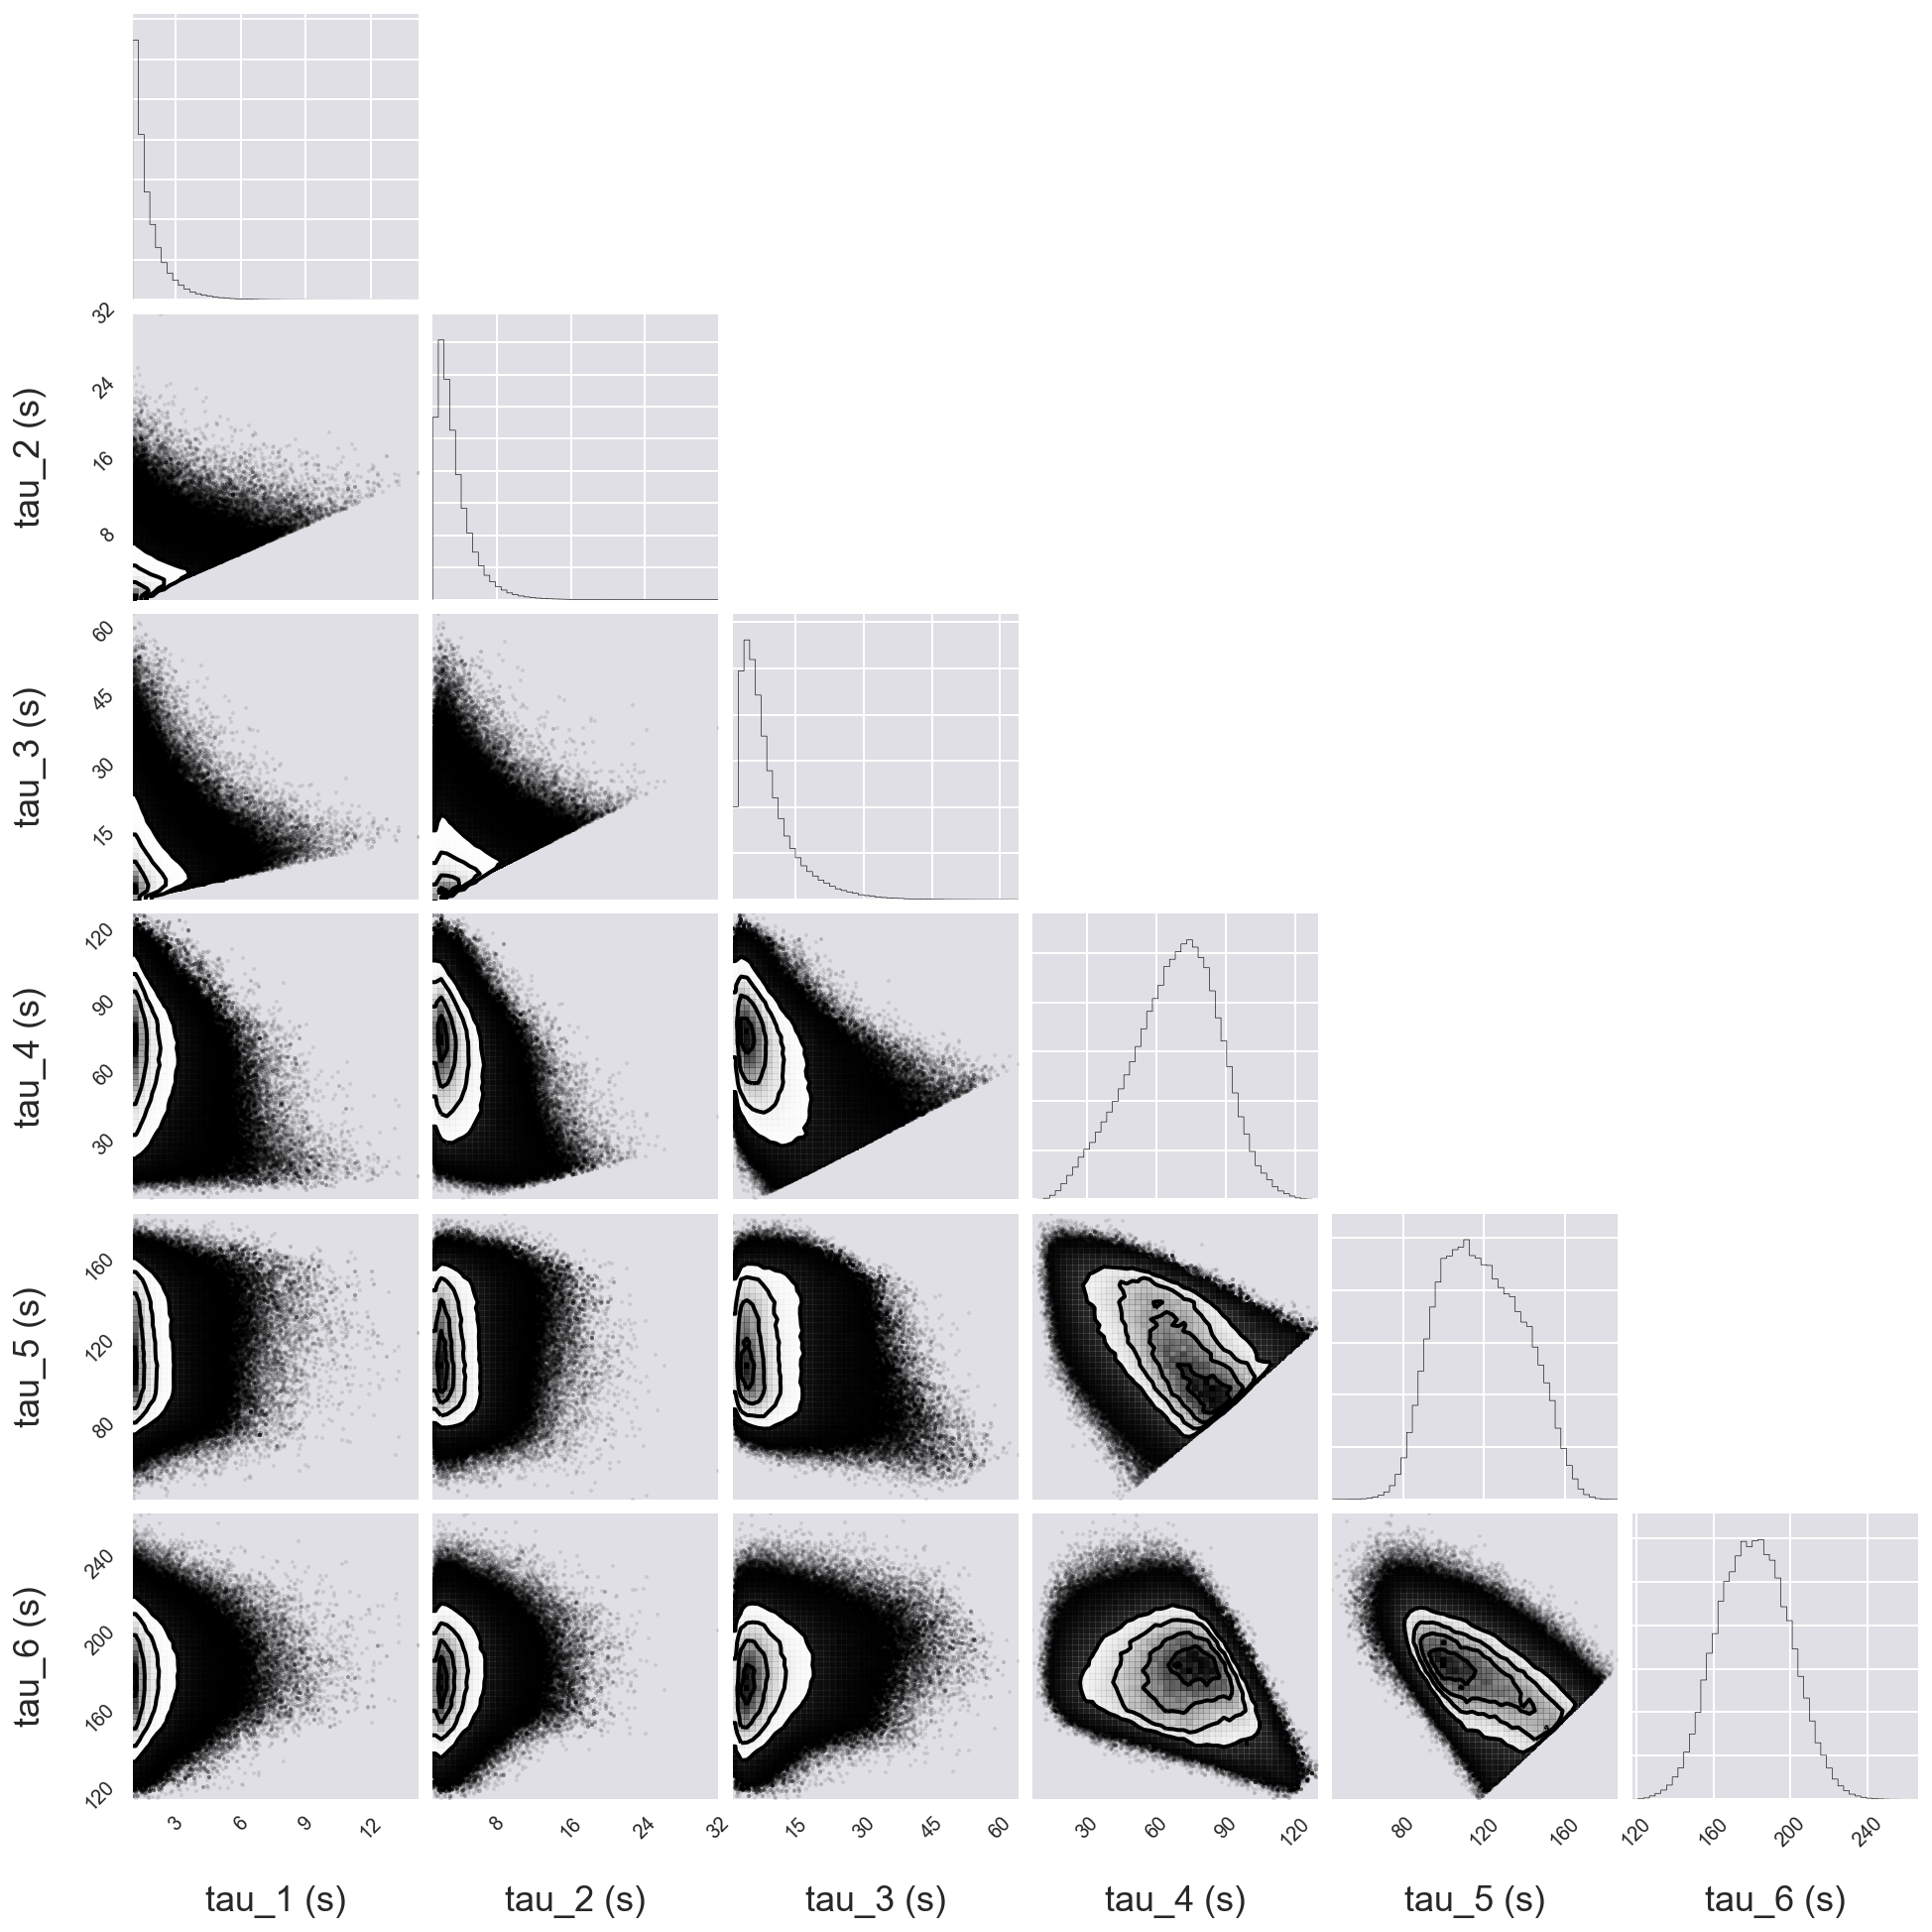

In [37]:
m = 6
df_ = pd.read_csv('ptmcmc_results_tau_' + str(m) + '.csv')
corner.corner(df_[df_.beta_ind==0].filter(regex='tau'), bins=50);

The trend is clear.  There must be at least three steps.  Beyond that, there may be more fast steps, but the three slow steps are always the same regardless of the model.  The fast steps do not seem to be necessary to describe the data, as 

\begin{align}
P(m=3\mid D, I) < P(m=4\mid D, I) < P(m=5\mid D, I) < P(m=6\mid D, I), 
\end{align}

a trend that likely continues.

So, we will take $m=3$ as our most probable model, but bear in mind that it is not at all unlikely that there may be some faster steps involved in the process.  Importantly, we know **there are three slow steps**.

We can visualize the results of the parameter estimation by plotting the ECDF with sample CDFs from the MCMC samples.

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


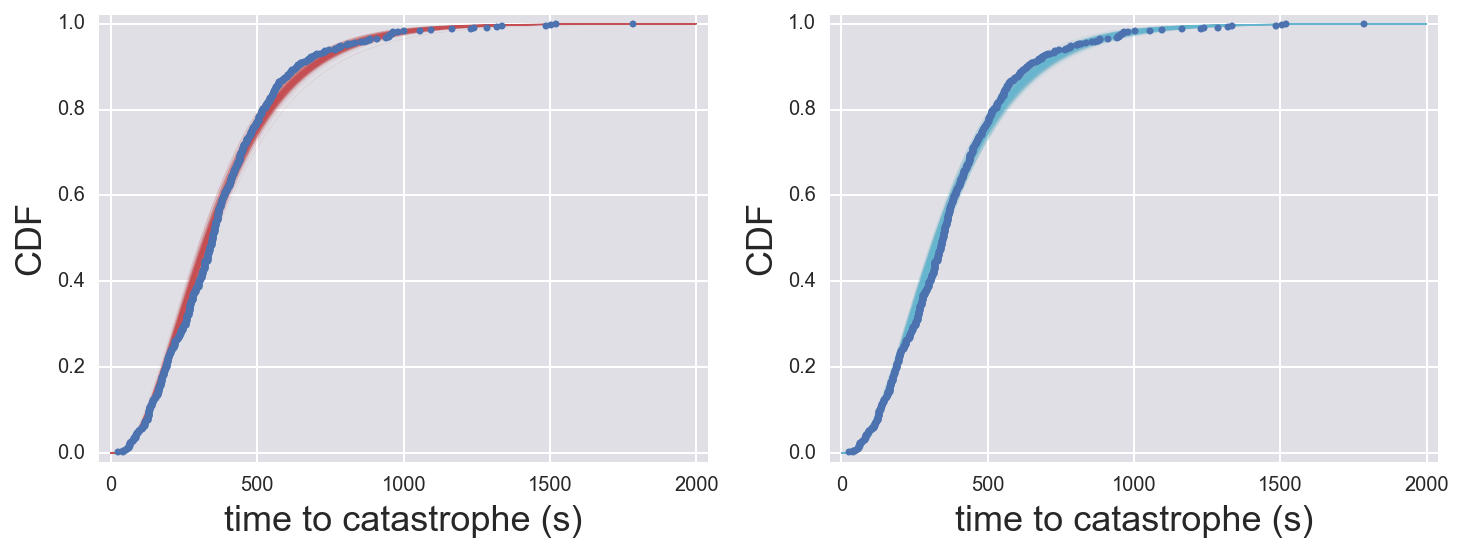

In [38]:
def plot_cdf(t, m, ax=None, color=None):
    """
    Function to plot ECDF with CDFs from 
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    if color is None:
        color = sns.color_palette()[2]
    
    # Construct ECDF
    y = np.arange(1, len(t) + 1) / len(t)
    ax.plot(t, y, '.', zorder=2)

    # Load DataFrame
    fname = 'ptmcmc_results_tau_' + str(m) + '.csv'
    df_ = pd.read_csv(fname)
    inds = df_['beta_ind']==0
    df_ = df_[inds]
    
    # Specify columns
    columns = ['tau_' + str(i) + ' (s)' for i in range(1, m+1)]

    # Draw 500 samples to plot
    t_plot = np.linspace(0, 2000, 200)
    dt = t_plot[1] - t_plot[0]
    for _ in range(500):
        i = np.random.choice(df_.index)
        tau = df_.loc[i, columns].values
        pdf = np.exp(log_pdf(t_plot, tau))
        cdf = np.cumsum(pdf * dt)
        ax.plot(t_plot, cdf, '-', lw=0.2, color=color, alpha=0.2, zorder=1)

    ax.set_xlabel('time to catastrophe (s)')
    ax.set_ylabel('CDF')
    ax.margins(0.02)
    return ax

# Make plots 
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0] = plot_cdf(t, 3, ax=ax[0])
ax[1] = plot_cdf(t, 4, ax=ax[1], color=sns.color_palette()[5])

We see systematic problems with both $m=3$ and $m=4$.  There is a sudden change in slope in the ECDF around 250 s that cannot be explained by the models.

**d)** Using the $m=3$ model, we will perform ensemble MCMC to do the parameter estimation.  Before proceeding, we'll get the MAP and 95% HPD for the 12 µM tubulin samples.

In [112]:
def map_and_hpd(df, tubulin_conc):
    """
    Given a DataFrame with MCMC samples, return map and HPD
    for m = 3 model
    """
    # Compute MAP and HPD
    s['tubulin_conc'] = tubulin_conc
    for i in [1, 2, 3]:
        tau_pre = 'tau_' + str(i)
        s[tau_pre + ' MAP'] = df.loc[df_['lnprob'].idxmax(), tau_pre + ' (s)']
        s[tau_pre + ' hpd_low'], s[tau_pre + ' hpd_high'] = \
            bebi103.hpd(df[tau_pre + ' (s)'], 0.95)

    return s

# Create DataFrame to store results
columns = ['tau_' + str(i) + ' MAP' for i in [1, 2, 3]] \
        + ['tau_' + str(i) + ' hpd_low' for i in [1, 2, 3]] \
        + ['tau_' + str(i) + ' hpd_high' for i in [1, 2, 3]]
columns = ['tubulin_conc'] + list(sorted(columns))
df_tau = pd.DataFrame(columns=columns)

# Put in DataFrame
df_ = pd.read_csv('ptmcmc_results_tau_3.csv')
df_ = df_[df_['beta_ind']==0]
s = map_and_hpd(df_, 12)
df_tau.loc[0] = s

# Print result
for i in [1, 2, 3]:
    tau_pre = 'tau_' + str(i)
    print("""
    tau_{0:d} = [{1:.2f}    {2:.2f}    {3:.2f}] seconds
    """.format(i, s[tau_pre + ' hpd_low'], 
                  s[tau_pre + ' MAP'], 
                  s[tau_pre + ' hpd_high']))


    tau_1 = [56.53    77.35    114.80] seconds
    

    tau_2 = [92.90    132.20    153.00] seconds
    

    tau_3 = [137.90    165.10    207.90] seconds
    


Now, we'll go through each tubulin concentration and compute the $\tau$ values and the HPD.  We'll write a couple convenient functions for the sampling.

In [113]:
def walker_starting_points_ensemble(m, n_walkers, tau_min, tau_max):
    """
    Generate walker starting positions for Ensemble MCMC
    """
    p0 = walker_starting_points(m, 1, n_walkers, tau_min, tau_max)
    return p0.reshape((n_walkers, m))


def log_posterior(tau, t, tau_min, tau_max, eps=1e-6):
    """
    Log posterior.
    """
    lp = log_prior(tau, tau_min, tau_max, eps=eps)
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood(tau, t)


def sample_mcmc(t, m, tau_min=1, tau_max=2000, n_walkers=100, 
                n_burn=100, n_steps=500, threads=None):
    
    # Starting points of walkers
    p0 = walker_starting_points_ensemble(m, n_walkers, tau_min, 300)
    
    # Columns for output DataFrame
    columns = ['tau_' + str(i) + ' (s)' for i in range(1, m+1)]
    
    return bebi103.run_ensemble_emcee(
        log_posterior, n_burn, n_steps, p0=p0, args=(t, tau_min, tau_max), 
        threads=threads, columns=columns)

We can now do our sampling, storing the MAP and HPD as we go.

In [114]:
concs = list(df['tubulin conc (µM)'].unique())
concs.remove(12)
for tubulin_conc in concs:
    print('Performing MCMC for [tubulin] = {0:d} µM....'.format(tubulin_conc),
          flush=True)
    
    # Extract data
    t = df.loc[df['tubulin conc (µM)'] == tubulin_conc,
                'time to catastrophe (s)'].values
    t.sort()
    
    #  Run MCMC
    df_mcmc = sample_mcmc(t, 3, tau_min=1, tau_max=2000, n_walkers=100, 
                          n_burn=1000, n_steps=2000, threads=6)
    
    # Store results
    s = map_and_hpd(df_mcmc, tubulin_conc)
    df_tau.loc[len(df_tau)] = s

Performing MCMC for [tubulin] = 7 µM....
Performing MCMC for [tubulin] = 9 µM....
Performing MCMC for [tubulin] = 10 µM....
Performing MCMC for [tubulin] = 14 µM....


Let's make a plot of the $\tau$ values and their HPDs.

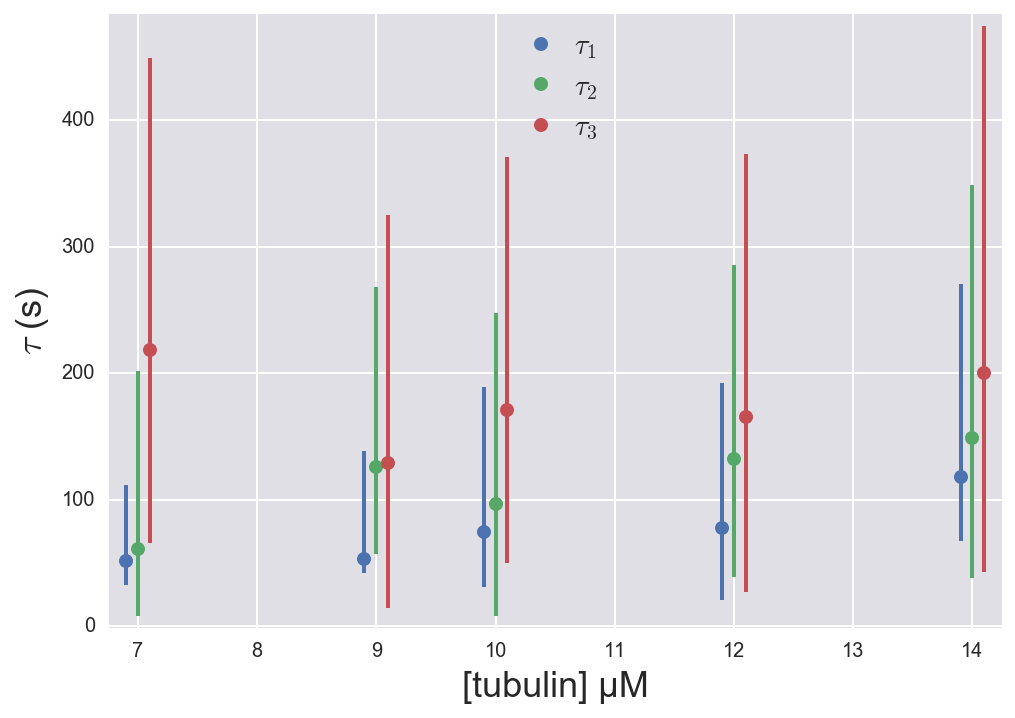

In [125]:
# Plot respective taus
for i in [1, 2, 3]:
    x = df_tau['tubulin_conc'] + (i - 2) * 0.1
    tau_pre = 'tau_' + str(i)
    plt.errorbar(x, df_tau[tau_pre + ' MAP'],
                 yerr=(df_tau[tau_pre +' hpd_low'], 
                       df_tau[tau_pre + ' hpd_high']),
                 marker='o', linestyle='none')

plt.legend((r'$\tau_1$', r'$\tau_2$', r'$\tau_3$'), loc='upper center', 
           fontsize=14)
plt.xlabel('[tubulin] µM')
plt.ylabel(r'$\tau$ (s)')
plt.margins(0.02)

There is some variation between tubulin concentrations in the rate of catastrophe, but nothing beyond what is covered by the respective credible regions.  Thus, microtubule catastrophe rates are *independent* of tubulin concentration. Because microtubules grow faster with more tubulin, catastrophe is also independent of microtubule length.

**e)** We leave this open to you, and look forward to hearing about your responses.

<br />
<br />

### Problem 6.2: Spike sorting, 30 pts

Dawna and Kyu kindly provided us with another set of voltage measurements from a mouse retina.  You can download the data [here](../data/H930start2filt.txt.zip).  These data have been pre-filtered, so you do not need to do any filtering, unless you think it will help your analysis.  For this trace:

**a)** Locate all spikes.

**b)** There are two types of spikes.  Devise a way to automatically tell the difference between each type of spike.  Plot all of the spikes overlayed on top of each other with their minima at the same point.  The plot should be color-coded so that two classes of spikes have different colors.

**c)** Plot the probability distributions of inter-spike times for each type of spike and comment on anything you see of note.

### Problem 6.2: solution
**a)** We start by loading in the data set and converting to NumPy arrays for faster indexing.

In [2]:
df = pd.read_csv('../data/bagherian_et_al/H930start2filt.txt', sep='\t',
                 comment='#', header=None, names=['time (ms)', 'V (µV)'])

t = df['time (ms)'].values
V = df['V (µV)'].values

Now, let's take a look at the signal.

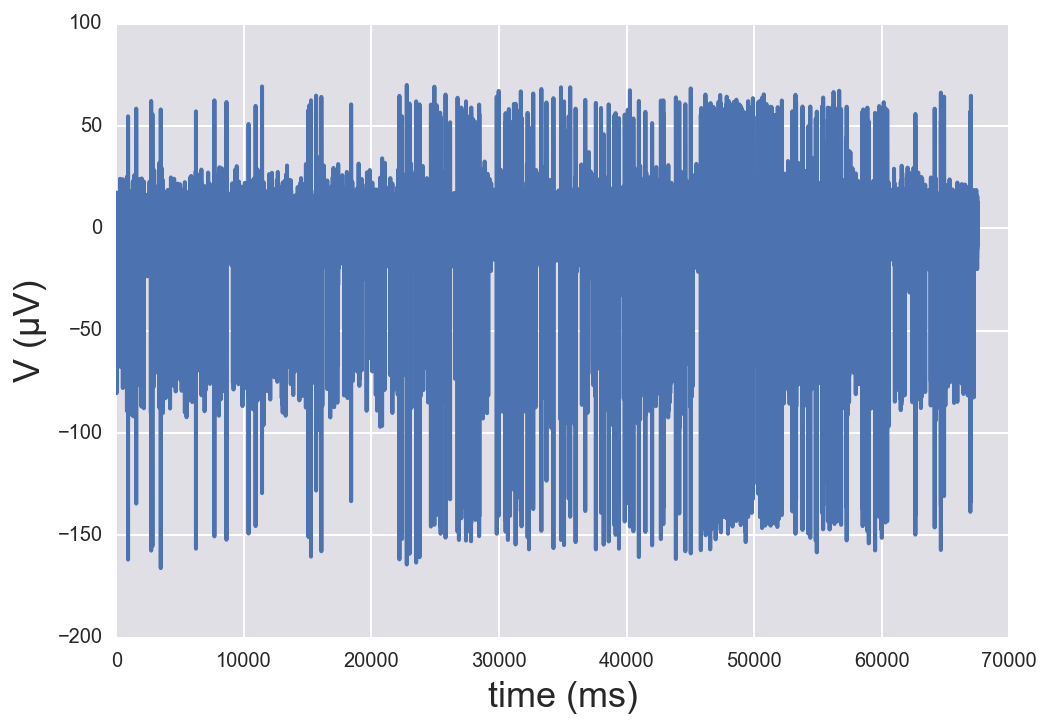

In [3]:
plt.plot(t, V, '-')
plt.xlabel('time (ms)')
plt.ylabel('V (µV)')

There appear to be two types of spikes, a deep one and a shallow one.  This is easier seen with Bokeh.

In [4]:
p = bokeh.charts.Line(df.loc[10000:30000,:], x='time (ms)', y='V (µV)', 
                      color='dodgerblue')
bokeh.io.show(p)

In zooming around the above plot, we can see to spikes between 2.70 and 2.73 seconds.

In [5]:
inds = (df['time (ms)'] > 2700) & (df['time (ms)'] < 2730)
p = bokeh.charts.Line(df.loc[inds,:], x='time (ms)', y='V (µV)', 
                      color='dodgerblue')
bokeh.io.show(p)

From the first plot, it appears as though all spikes cross a threshold of -60 µV, so we will identify spikes by downward crossings of -60 µV, followed by an upward crossing.  For each spike, we will fit the bottom three points to a quadrative to get sub-sampling localization of the spike.  To do this, we write a function to get the local min.

In [6]:
def local_min(x, y):
    """
    Fit three points to quadratic and return location of maximum or minimum.
    """
    a, b, c = np.polyfit(x, y, 2)
    x_max = -b / 2 / a
    return x_max, a*x_max**2 + b*x_max + c

Now we can find the spikes and locate their minima.

In [7]:
# Specify threshold
thresh = -60  # µV

# Find up and down crossing indices
up_crossing_inds = np.where(
            np.logical_and(V[:-1] < thresh, V[1:] >= thresh))[0] + 1
down_crossing_inds = np.where(
            np.logical_and(V[:-1] > thresh, V[1:] <= thresh))[0]

# Make sure downcrossings are first
if down_crossing_inds[0] > up_crossing_inds[0]:
    up_crossing_inds = up_crossing_inds[1:]
    
# Make sure upcrossing last
if up_crossing_inds[-1] < down_crossing_inds[-1]:
    down_crossing_inds = down_crossing_inds[:-1]
    
# Find maxima
t_spike = np.empty(len(down_crossing_inds))
V_spike = np.empty_like(t_spike)
ind_spike = np.empty(len(down_crossing_inds), dtype=int)
for i, dc in enumerate(down_crossing_inds):
    ind = dc + np.argmin(V[dc:up_crossing_inds[i]+1])
    t_spike[i], V_spike[i] = local_min(t[ind-1:ind+2], V[ind-1:ind+2])
    ind_spike[i] = ind

We can plot some of the spikes we've found to check.

In [8]:
# Set up the figure (this is like a canvas you will paint on)
p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                          plot_height=450)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label = 'time (ms)'
p.yaxis.axis_label = 'V (µV)'

# Specify the glyphs for the trace
t_plot = df.loc[:30000, 'time (ms)']
V_plot = df.loc[:30000, 'V (µV)']
p.line(t_plot, V_plot, color='dodgerblue')

# Glyphs for minima
t_spike_plot = t_spike[t_spike <= t_plot.max()]
V_spike_plot = V_spike[t_spike <= t_plot.max()]
for i, ts in enumerate(t_spike_plot):
    p.circle(ts, V_spike_plot[i], size=5, color='tomato')

bokeh.io.show(p)

Looks good!

**b)** Based on what we saw in zooming in on the plots of spikes, we should be able to discern one type of spike from another by looking at the difference in the minimum and maximum voltage in the neighborhood of a spike.  We will chose to look at the 21 points around the spike.  Let's look at the min/max difference of these.  WE will just look at the value of the absolute signal, not necessarily the minimum voltage we calculated when finding the spikes.

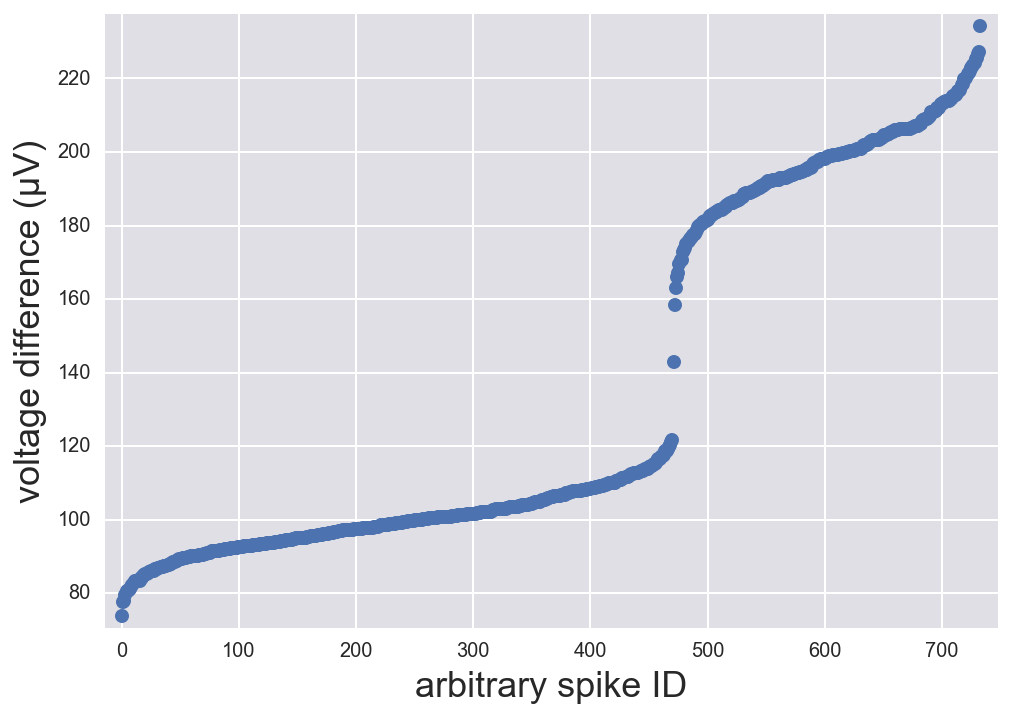

In [9]:
# Compute V differentials
V_diff = np.empty_like(t_spike)
for i, ind in enumerate(ind_spike):
    V_local = V[ind-10:ind+10]
    V_diff[i] = V_local.max() - V_local.min()
    
# Plot them.
plt.plot(np.sort(V_diff), 'o')
plt.xlabel('arbitrary spike ID')
plt.ylabel('voltage difference (µV)')
plt.margins(0.02)

There is a clear cutoff at 140 µV.  We will take this as our cutoff to sort the spikes.

In [10]:
# Make a DataFrame with spikes info
df_spike = pd.DataFrame(data={'ind': ind_spike, 
                              't_spike': t_spike, 
                              'V_diff': V_diff})

# Make a column with spike ID
df_spike['spike_id'] = np.ones(len(df_spike), dtype=int)
df_spike.loc[df_spike['V_diff'] > 140, 'spike_id'] = 0

Now that we have the spikes labeled, we can go ahead and plot them.

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/Justin/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:9: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


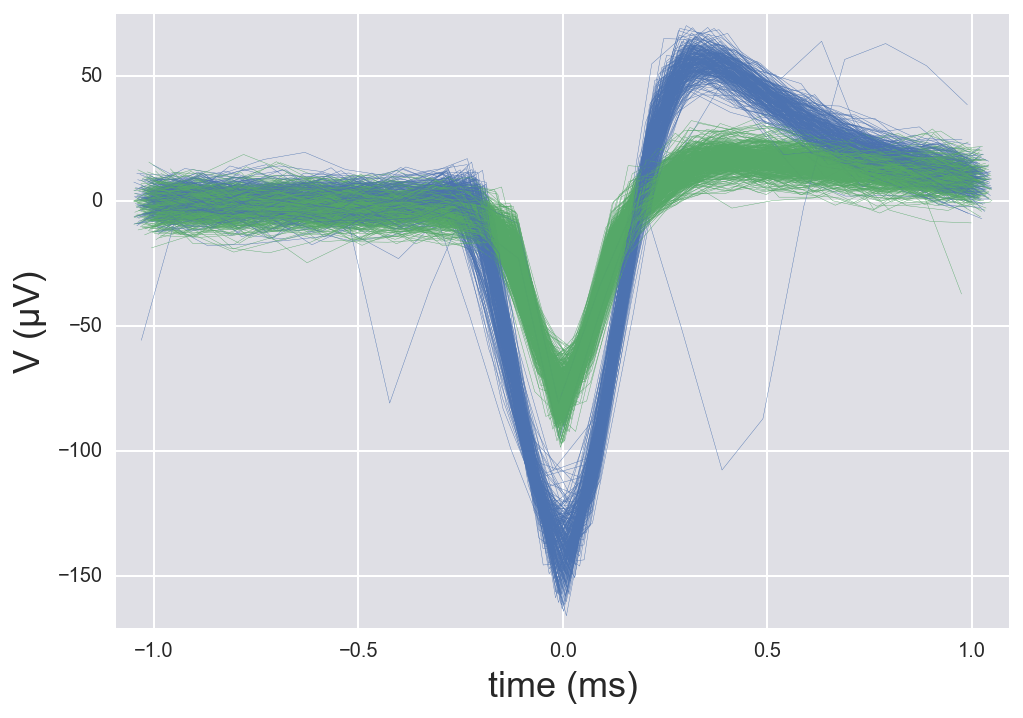

In [11]:
# Make plot
for i, ind in enumerate(ind_spike):
    # Determine time points for plotting
    t_plot = t[ind-10:ind+11] - t_spike[i]
    V_plot = V[ind-10:ind+11]
    
    # Set color based on spike type
    spike_type = df_spike[df_spike['ind']==ind]['spike_id'].values
    color = sns.color_palette()[spike_type]

    # Plot the spike
    plt.plot(t_plot, V_plot, '-', color=color, lw=0.2)
    
# Tidy plot
plt.xlabel('time (ms)')
plt.ylabel('V (µV)')
plt.margins(0.02)

**c)** To plot the interspike times, we just diff the times for the respective spike times.

In [12]:
t_diff = [np.diff(df_spike[df_spike['spike_id']==0]['t_spike'])]
t_diff.append(np.diff(df_spike[df_spike['spike_id']==1]['t_spike']))

Now we can plot the ECDFs.

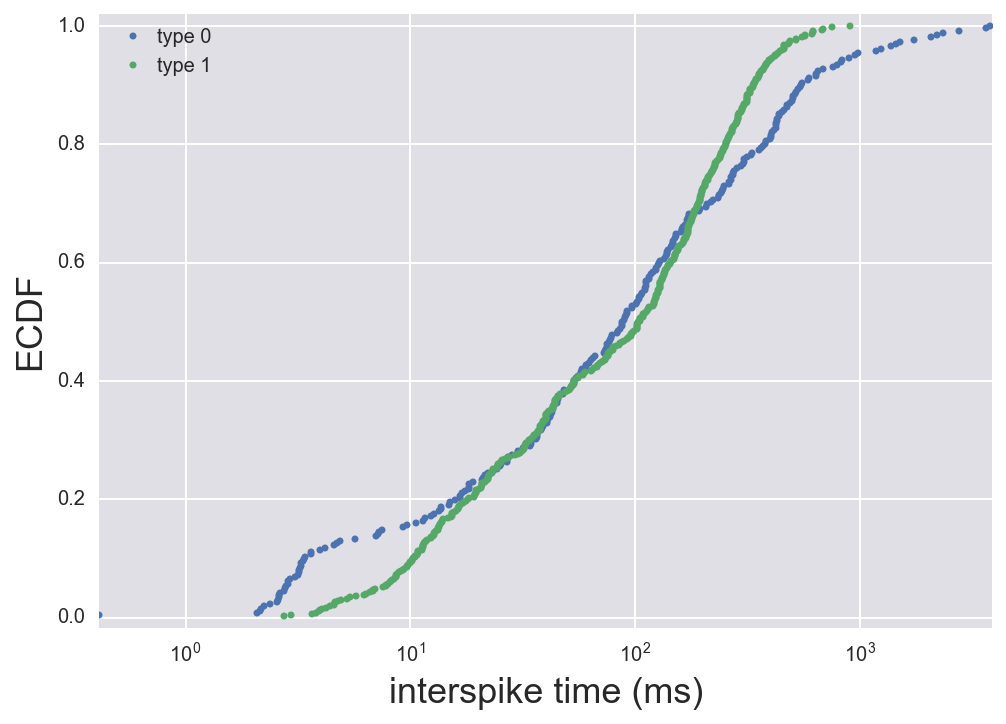

In [13]:
# Plot interspike distributions
for td in t_diff:
    x = np.sort(td)
    y = np.arange(1, len(x)+1) / len(x)
    plt.semilogx(x, y, '.')

# Tidy plot
plt.xlabel('interspike time (ms)')
plt.ylabel('ECDF')
plt.legend(('type 0', 'type 1'),loc='upper left')
plt.margins(0.02)

We see that the type zero results shows more very rapid spikes, and also more long delays between spiking.  They both have the same intermediate spiking rate.